Sometimes you may be interested in how long it takes until a certain event occurs, e.g. the first time a certain combination of mutations appears in the same cell. In these cases, it can be a waste of computational resources to continue running the simulation after this event has occurred.  

These cannot be used with the branching algorithm of in simulations with differentiated cells.  

This notebook describes how to define early stopping conditions for simulations.  


Note:  
Many of the results arrays are left empty or full of zeros at the times that have not been simulated.  
Be careful not to analyse the simulations after the point they have stopped and to ensure that the empty/zeroed parts of the arrays are not accidentally included in the analysis.   

In [1]:
import numpy as np
%matplotlib inline

In [2]:
from clone_competition_simulation import Parameters, EndConditionError, ColourScale
from clone_competition_simulation import MutationGenerator, Gene, NormalDist
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from collections import namedtuple

To use the early stopping feature, you need to pass a function to the `end_condition_function` argument of the Parameters class.   
This function must take a simulation as the only argument. If the function determines the stop condition has been met, then the function should raise an `EndConditionError`.  

The functions to use will depend on the project and will likely have to be written yourself.   
Here I'll demonstrate the use of these functions with a few examples.  

# Example 1: Surviving clone numbers

============== Setting up ==============
Using the default division rate: 1
2000 simulation_steps
	Times used: [ 0.   0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6
  2.8  3.   3.2  3.4  3.6  3.8  4.   4.2  4.4  4.6  4.8  5.   5.2  5.4
  5.6  5.8  6.   6.2  6.4  6.6  6.8  7.   7.2  7.4  7.6  7.8  8.   8.2
  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4 10.6 10.8 11.
 11.2 11.4 11.6 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2 13.4 13.6 13.8
 14.  14.2 14.4 14.6 14.8 15.  15.2 15.4 15.6 15.8 16.  16.2 16.4 16.6
 16.8 17.  17.2 17.4 17.6 17.8 18.  18.2 18.4 18.6 18.8 19.  19.2 19.4
 19.6 19.8 20. ]
Using the default mutation rate: 0
0 mutations to add
Steps completed:
100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, Finished 2000 steps


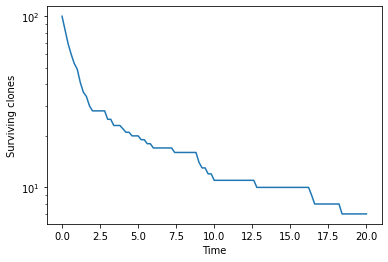

In [3]:
# First, here is a simulation without a stopping condition, run to the end. 
# Run a simulation of neutral competition, starting from 100 single-cell clones
np.random.seed(1)
p = Parameters(algorithm='Moran', initial_size_array=np.ones(100), print_warnings=True, progress=100, 
               max_time=20
              )
s = p.get_simulator()
s.run_sim()
s.plot_surviving_clones_for_non_mutation()

In [4]:
# Now add a stopping condition to that simulation
# Say we want to stop where there are only 10 surviving clones left

def stop_when_10_clones_left(sim):
    """
    Stop the simulations when there are only 10 suriviving clones.  
    """
    # Get the slice of the population_array at the current time
    # plot_idx is the *next* column index of the population array, 
    # so plot_idx-1 holds the latest index 
    current_clones = sim.population_array[:, sim.plot_idx-1]
    
    # Count the number of clones with at least one cell alive
    num_surviving = (current_clones > 0).sum()
    
    if num_surviving <= 10:  # If ten or fewer clones left, stop the simulation. 
        # If you want to save some feature of the simulation for later access, can assign it to a class attribute
        # self.stop_condition_result is an empty attribute there for this purpose, but any new attribute can be used
        # Record the time that the simulation stopped
        sim.stop_condition_result = sim.times[sim.plot_idx-1]
        raise EndConditionError()
        
        
# Run a simulation of neutral competition, starting from 100 single-cell clones
np.random.seed(1)
p = Parameters(algorithm='Moran', initial_size_array=np.ones(100), print_warnings=True, progress=100, 
               max_time=20, end_condition_function=stop_when_10_clones_left  # Pass the stop function in
              )
s = p.get_simulator()
s.run_sim()

============== Setting up ==============
Using the default division rate: 1
2000 simulation_steps
	Times used: [ 0.   0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6
  2.8  3.   3.2  3.4  3.6  3.8  4.   4.2  4.4  4.6  4.8  5.   5.2  5.4
  5.6  5.8  6.   6.2  6.4  6.6  6.8  7.   7.2  7.4  7.6  7.8  8.   8.2
  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4 10.6 10.8 11.
 11.2 11.4 11.6 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2 13.4 13.6 13.8
 14.  14.2 14.4 14.6 14.8 15.  15.2 15.4 15.6 15.8 16.  16.2 16.4 16.6
 16.8 17.  17.2 17.4 17.6 17.8 18.  18.2 18.4 18.6 18.8 19.  19.2 19.4
 19.6 19.8 20. ]
Using the default mutation rate: 0
0 mutations to add
Steps completed:
100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 

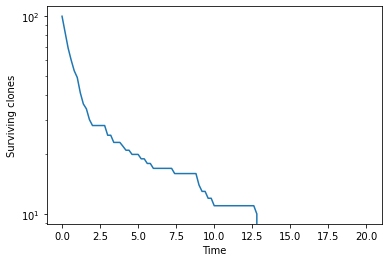

In [5]:
# The simulation has stopped early. 
s.plot_surviving_clones_for_non_mutation()
# Note the surviving clones drops to zero after the simulation is stopped. 
# Make sure not to analyse after the stopping point

In [6]:
# The simulation stopped at t=12.8
s.stop_condition_result

12.8

# Example 2: Sweeping clone

A similar example to above. 

Simulations to see how long mutants take to entirely cover a tissue.  
If the simulation time is fixed, then we risk either stopping the simulation before the mutants fully sweep the tissue or needlessly continuing the simulation for a long time after the sweep has occurred.   

Instead, we can use the early stopping conditions to halt the simulation as soon as there are no wild type cells left. 

In [7]:
# I'll set up a colour scale here to plot the wild type (initial clones) and mutant clones in different colours
# See the Colours tutorial notebook for an explanation

Key1 = namedtuple('key1', ['initial', ])

cs1 = ColourScale(
    colourmaps={
        Key1(initial=True): cm.Blues,  # Initial clones are blue
        Key1(initial=False): cm.Reds   # Later clones are red
    }, 
    use_fitness=False
)


In [8]:
# Run a simulation with ongoing mutation.  
np.random.seed(0)
p = Parameters(algorithm='Moran2D', initial_cells=10000, print_warnings=False, 
               progress=100000, mutation_rates=0.2,   # Use the default mutation generator 
               colourscales=cs1,
               max_time=50   # Run up to time 50.
              )
s = p.get_simulator()
s.run_sim()

100184 mutations to add
Steps completed:
100000, 200000, 300000, 400000, 500000, Finished 500000 steps


/Users/mh28/PycharmProjects/clone-competition-simulation/clone_competition_simulation/animator.py:213: MatplotlibDeprecationWarning: 
The 'offset_position' parameter of __init__() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. If any parameter follows 'offset_position', they should be passed as keyword, not positionally.
  self.col = collections.PolyCollection(
/Users/mh28/PycharmProjects/clone-competition-simulation/clone_competition_simulation/animator.py:213: MatplotlibDeprecationWarning: 
The set_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self.col = collections.PolyCollection(
/Users/mh28/miniconda3/envs/competition_jup/lib/python3.8/site-packages/IPython/core/events.py:89: MatplotlibDeprecationWarning: Support for offset_position='data' is deprecated since 3.3 and will be removed two minor releases later.
  func(*args, **kwargs)
/Users/mh28/miniconda3/envs/competition_jup/lib/python3.8/s

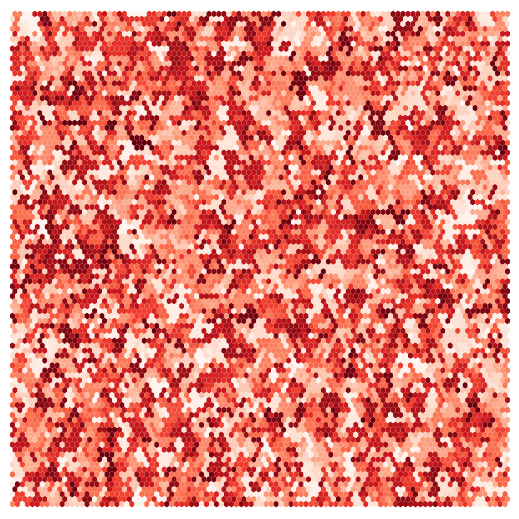

In [9]:
# At the end of the simulation, t=50, there are no wild type (blue) cells left in the grid.  
s.plot_grid(figsize=(5, 5));

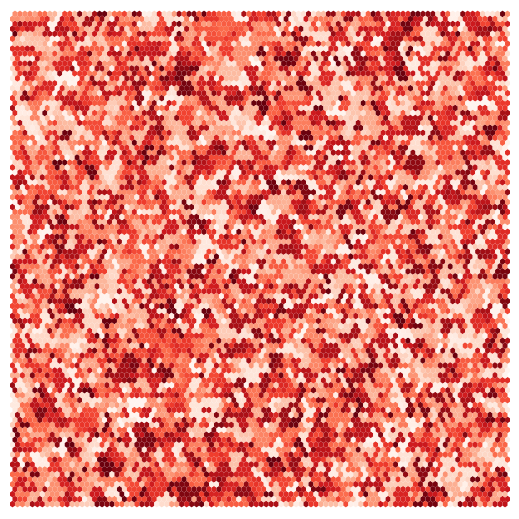

In [10]:
# But at t=40, there were also no wild type cells left in the grid. 
# We didn't have to run the simulation for so long.  
s.plot_grid(figsize=(5, 5), t=40);

In [11]:
def stop_when_fully_mutant(sim):
    """
    Stops the simulation when the entire tissue is mutant.
    """
    # The initial clones are at the top of the population array
    # For this simulation, there is a single initial clone, and it is the first row of the array
    WT_pop = sim.population_array[0, sim.plot_idx-1]
    if WT_pop == 0:
        # Again, record the time that the simulation stopped
        sim.stop_condition_result = sim.times[sim.plot_idx-1]
        raise EndConditionError()
        
        
# Run again with the stop condition.  
np.random.seed(0)
p = Parameters(algorithm='Moran2D', initial_cells=10000, print_warnings=False, 
               progress=100000, mutation_rates=0.2,   # Use the default mutation generator 
               colourscales=cs1,
               end_condition_function=stop_when_fully_mutant,
               max_time=50 
              )
s = p.get_simulator()
s.run_sim()
# Print the time the simulation stopped
print('\nEnd time:', s.stop_condition_result)

100184 mutations to add
Steps completed:
100000, 200000, 300000, 
End time: 33.5


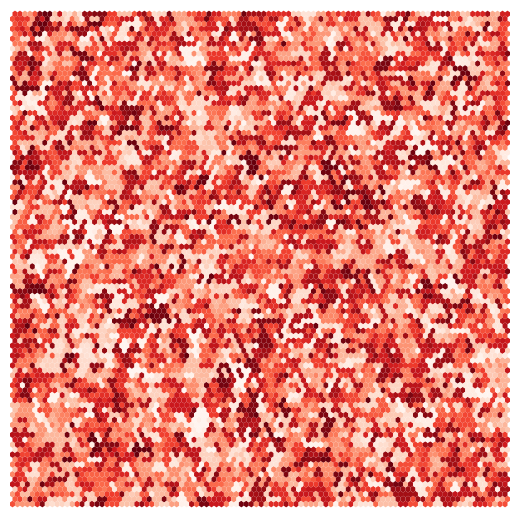

In [12]:
# At the last recorded time point, there are no wild type cells left
s.plot_grid(figsize=(5, 5));

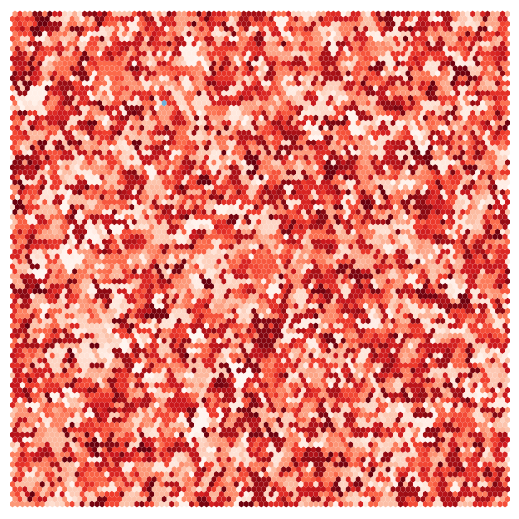

In [13]:
# At the previous time point (we select the second last grid produced during the simulation),
# you can see there is a single wild type cell left in this grid (if you look closely)
s.plot_grid(figsize=(5, 5), t=-2, index_given=True);

# Example 3: double mutants

Say we have two genes. We are interested in how long it takes until the first occurrence of a double mutant cell.   

In [14]:
# Set up the genes
# Use a multi_gene_array=True so we can easily tell which genes are mutated in which clones. 
mut_gen = MutationGenerator(
    genes=[
        Gene('Gene1', NormalDist(mean=1.1, var=0.1), synonymous_proportion=0),
        Gene('Gene2', NormalDist(mean=1, var=0.01), synonymous_proportion=0)
    ], 
    multi_gene_array=True
)

In [15]:
# Define the early stopping function

def stop_when_both_genes_mutated(sim):
    
    # The columns of the raw_fitness_array will be [WT fitness, Gene1 fitness, Gene2 fitness]
    # If Gene1 or Gene2 are not mutated, the value will be NaN. WT_fitness will never be NaN.
    # Therefore, rows with no NaN values will have both genes mutated. 
    
    # This one-line checks for any rows with no NaN values. 
    # 1. Check if each value in the array is NaN with np.isnan(sim.raw_fitness_array)
    # 2. Check if each row contains any NaN values with np.isnan(sim.raw_fitness_array).any(axis=1)
    # 3. Then reverse that with ~ to set rows without any NaN values to True
    # 4. Then check if any rows have a True value with np.any(~np.isnan(sim.raw_fitness_array).any(axis=1))
    if np.any(~np.isnan(sim.raw_fitness_array).any(axis=1)):
        
        # Save the last time point to stop_condition_result
        sim.stop_condition_result = sim.times[sim.plot_idx-1]  
        raise EndConditionError()

In [16]:
# Set up a colourscale
Key2 = namedtuple('key1', ['genes_mutated', ])

cs2 = ColourScale(
    colourmaps={
        # No genes mutated, light blue colour
        Key2(genes_mutated=(0,)): cm.ScalarMappable(norm=Normalize(vmin=0, vmax=2), cmap=cm.Blues).to_rgba,  
        
        # First gene mutated, Red
        Key2(genes_mutated=(0, 1,)): cm.ScalarMappable(norm=Normalize(vmin=-2, vmax=2), cmap=cm.Reds).to_rgba, 
        
        # Second gene mutated, yellow
        Key2(genes_mutated=(0, 2,)): cm.ScalarMappable(norm=Normalize(vmin=-20, vmax=2), cmap=cm.inferno).to_rgba,
        
        # Both genes mutated, purple
        Key2(genes_mutated=(0, 1, 2)): cm.ScalarMappable(norm=Normalize(vmin=-5, vmax=1), cmap=cm.Purples).to_rgba
    }, 
    use_fitness=False
)

In [17]:
# Run a simulation with the stop condition.  
np.random.seed(1)
p = Parameters(algorithm='Moran2D', initial_cells=10000, print_warnings=False, 
               progress=100000, 
               mutation_generator=mut_gen, 
               mutation_rates=0.001,   
               colourscales=cs2,
               end_condition_function=stop_when_both_genes_mutated,
               max_time=50 
              )
s = p.get_simulator()
s.run_sim()
# Print the time the simulation stopped
print('\nEnd time:', s.stop_condition_result)

468 mutations to add
Steps completed:
100000, 200000, 300000, 
End time: 32.5


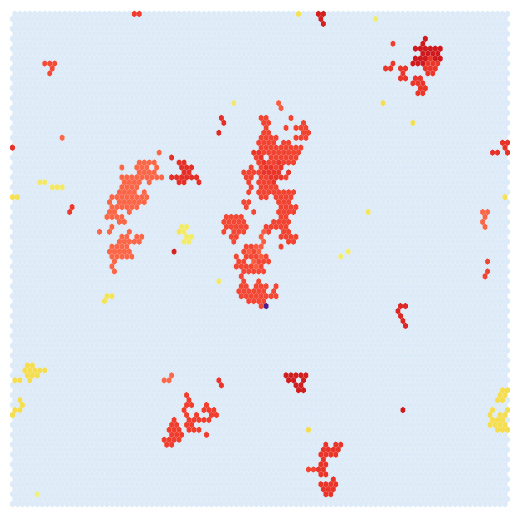

In [18]:
# Can see the single cell with the double mutation in purple (middle, just below centre)
s.plot_grid(figsize=(5, 5))